### Importing the required packages

In [1]:
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

### Loading the data

In [2]:
df = pd.read_csv('..\data\spam.csv', delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Dropping the unwanted columns

In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.columns = ['Label', 'Text']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
Text     5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


### Plotting the class distribution

Text(0.5, 1.0, 'Ham vs Spam')

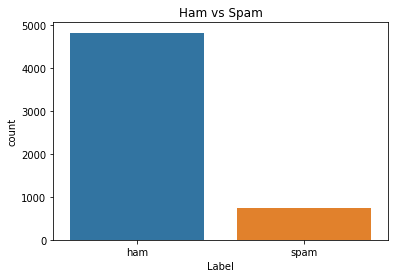

In [4]:
sns.countplot(df['Label'])
plt.xlabel('Label')
plt.title('Ham vs Spam')

### Creating input output vectors and encode the labels.

In [5]:
X = df['Text']
Y = df['Label']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

### Splitting into training and test data.

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

### Processing the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Defining the network structure

In [8]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

### Compiling the model

In [9]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

### Initiating model training

In [10]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 7s 2ms/sample - loss: 0.4611 - accuracy: 0.8606 - val_loss: 0.2967 - val_accuracy: 0.8543
Epoch 2/10
3565/3565 [==============================] - 4s 1ms/sample - loss: 0.1862 - accuracy: 0.9201 - val_loss: 0.1113 - val_accuracy: 0.9697
Epoch 3/10
3565/3565 [==============================] - 4s 1ms/sample - loss: 0.0676 - accuracy: 0.9806 - val_loss: 0.0717 - val_accuracy: 0.9787
Epoch 4/10
3565/3565 [==============================] - 5s 1ms/sample - loss: 0.0358 - accuracy: 0.9891 - val_loss: 0.0730 - val_accuracy: 0.9765


The model performs well on the validation set and this configuration is chosen as the final model.

### Processing the test data for model evaluation

In [11]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

### Evaluating the model on the test set.

In [12]:
accr = model.evaluate(test_sequences_matrix,Y_test)

1115/1115 [==============================] - 1s 893us/sample - loss: 0.0464 - accuracy: 0.9865


In [13]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.046
  Accuracy: 0.987


In [14]:
Y_pred = model.predict(test_sequences_matrix)
Y_pred = (Y_pred>0.5).astype(int)

In [15]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[950   9]
 [  6 150]]


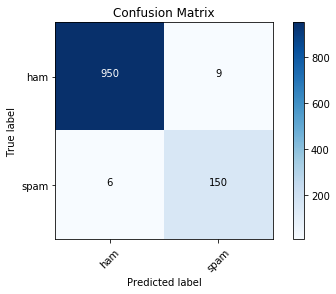

In [16]:
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm=cm, classes=['ham', 'spam'], title='Confusion Matrix')

In [17]:
print(classification_report(Y_test, Y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       959
           1       0.94      0.96      0.95       156

    accuracy                           0.99      1115
   macro avg       0.97      0.98      0.97      1115
weighted avg       0.99      0.99      0.99      1115



### Saving the model

In [18]:
model.save('..\model\model_v1.h5')

### Saving the tokenizer

In [19]:
tokenizer_json = tok.to_json()
with open(r'..\model\tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

### Performance tuning approaches:
1. Try feeding the cleaned data
2. The performance of the model can be increased by employing data augmentation technique or feeding more training samples.
3. There is a chance of improvement in model performance if we use more sophisticated word embedding techniques such as Word2Vec, GloVE, etc.
4. We can also try different learning optimizers, tweak learning rate, etc.